In [43]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [44]:
def f(x):
    return 6 - 13 * x - 5 * x ** 2 - 4 * x ** 3

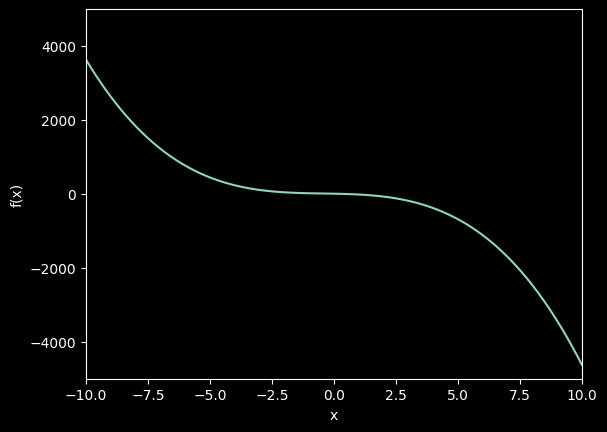

In [45]:
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)
plt.plot(dots, f(dots))
plt.show()

In [46]:
# min bias, max variance
x_datas = []
f_datas = []

for i in range(10):
    x_data = np.random.uniform(-10, 10, 20)
    x_datas.append(x_data)
    f_datas.append([f(i) for i in x_data] + np.random.uniform(-500, 500, 20))

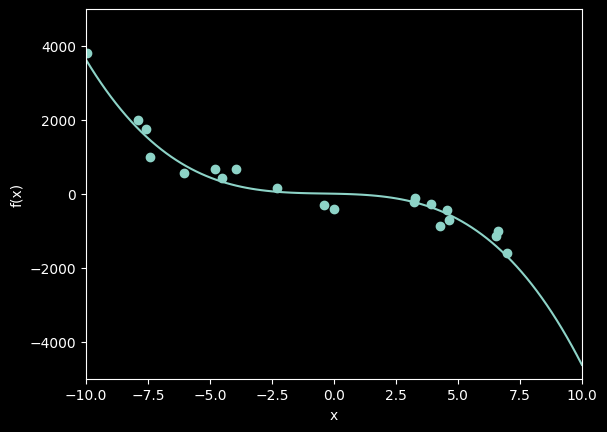

In [47]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)
plt.plot(dots, f(dots))
plt.scatter(x_datas[0], f_datas[0])
plt.show()

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [50]:
regressors = []
for i in range(10):
    # create model
    regressor = DecisionTreeRegressor(random_state=10, max_depth=10)
    regressor.fit(np.reshape(x_datas[i], (-1, 1)), f_datas[i])
    regressors.append(regressor)

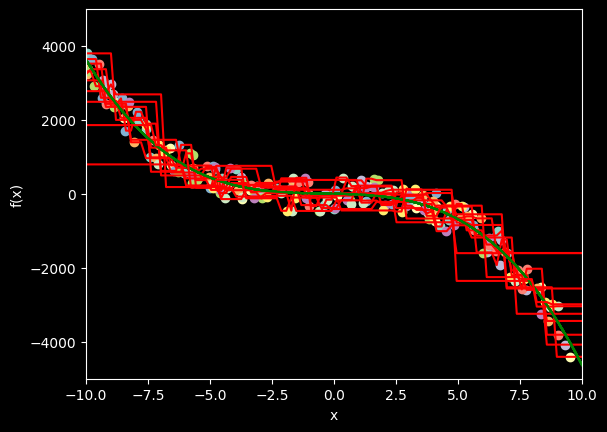

In [52]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10, 10)

predictions = []
for i in range(10):
    plt.plot(dots, f(dots), c='g')
    plt.scatter(x_datas[i], f_datas[i])
    prediction = regressors[i].predict(np.reshape(dots, (-1, 1)))
    predictions.append(prediction)
    plt.plot(dots, prediction, c='r')
predictions =np.array(predictions)
